# **Tarea 2**: Grafos de Recetas
**Asignatura**: MII797 - Ciencia de Redes

**Profesores**: Wenceslao Palma, Javier Vera

**Estudiante**: Máximo Arnao Molina

**Fecha de entrega**: 24 de Octubre de 2020

## Parte 1: Construcción de la red de recetas

### 1.a Construyendo la red

A continuación, se construye la red de recetas en la cual cada nodo representa un ingrediente, además los nodos se conectan mediante aristas, las que indican que el par de ingredientes está presente en una misma receta. Las aristas tienen un peso asociado el cual depende de cuántas veces un par de ingredientes está presente en una misma receta.

<span style="color:red"> 

- Trata de explicar un poco más y con mád detalle cómo construiste las redes
- Falta una pequeña introducción sobre qué es la tarea

</span>

Primero, se importan los datos presentes en un archivo JSON que contiene un arreglo de objetos que representan las recetas. Cada receta se compone de un identificador único, la cocina a la cual pertenece y una lista (arreglo) de ingredientes.

In [1]:
import json

In [2]:
def load_data():
    with open('train.json') as file:
        return json.load(file)

data = load_data()

In [2]:
#data

Segundo, se procesan los datos para crear el grafo: se recorren las diferentes recetas y para cada una se obtienen sus ingredientes los cuales son agregados como nodos al grafo, luego se relacionan los ingredientes con sus pares de la misma receta, en este paso se verifica si la relación entre ingredientes ya existe, en caso de ser afirmativo se aumenta el peso de la arista, de lo contrario se agrega una nueva arista con peso 1.

<span style="color:red"> 

- Trata de ser un poco más preciso. Imagina que con tus instrucciones alguien podría reproducir los grafos que implementaste

</span>

In [4]:
import networkx as nx

In [5]:
G = nx.Graph()
cuisines = set()
for idx, recipe in enumerate(data):
    cuisines.add(recipe['cuisine'])
    G.add_nodes_from(recipe['ingredients'])
    for source_idx, source_ingredient in enumerate(recipe['ingredients']):
        for target_idx in range(source_idx + 1, len(recipe['ingredients'])):
            if(G.has_edge(source_ingredient, recipe['ingredients'][target_idx])):
                G[source_ingredient][recipe['ingredients'][target_idx]]['weight'] += 1
            else:
                G.add_edge(source_ingredient, recipe['ingredients'][target_idx], weight = 1)

### 1.b Describiendo la red

Se han extraído ciertos datos relevantes acerca de la composición de la red generada y otro derivados. Entre los datos más importantes se incluyen: la cantidad total de cocinas según las recetas, la cantidad de nodos, aristas, componentes conexas y el peso promedio aproximado de las aristas.

Como se puede notar, la cantidad de nodos y aristas es de 6714 y 479.947 respectivamente, las que son suficientemente altas como para poder representar gráficamente la red, más adelante se ve en detalle esta dificutlad.

Por otra parte, el grafo es conexo ya que tiene solo 1 componente conexa, por lo que tiene un alto grado de conectividad.

Además, el peso promedio de las aristas es de 5, es decir que en promedio un mismo par de ingredientes se encuentra en 5 recetas distintas.

<span style="color:red"> 

- Está ok esta parte. Sin embargo, revisa un poco la redacción y la ortografía. 

</span>

In [6]:
import pandas as pd

In [7]:
G_description = {
    'Cantidad de cocinas': len(cuisines),
    'Cantidad de nodos': G.number_of_nodes(),
    'Cantidad de aristas': G.number_of_edges(),
    'Cantidad de componentes conexas': nx.number_connected_components(G),
    'Peso promedio de aristas': round(sum([edge[2]['weight'] for edge in G.edges(data = True)]) / G.number_of_edges())
}

G_description_df = pd.DataFrame.from_dict(G_description, orient = 'index', columns = ['Valor'])
G_description_df

Valor
Cantidad de cocinas                  20
Cantidad de nodos                  6714
Cantidad de aristas              479947
Cantidad de componentes conexas       1
Peso promedio de aristas              5

### 1.c Visualizando la red

A continuación, se respresenta visualmente el grafo. Tal como se ha indicado anteriormente, debido al alto número de nodos y especialmente de aristas, ha sido necesario podar el grafo quitando: aquellos nodos con bajo grado de centralidad, dejando a los 500 con mayor grado de centralidad; y a aquellas aristas que tienen un peso bajo el promedio. Cabe destacar que el promedio de peso al momento de quitar dichas aristas ya no es de 5, sino que de 18 aproximadamente, ya que se debe recordar que se han eliminado nodos al grafo.

<span style="color:red"> 

- Quizás sería mejor que cuando expliques procedimientos, lo hagas con enumeración. Eso puede ayudarte a ordenar mejor las ideas

</span>

Se han intentado extraer nodos en base a la medida de centralidad Betweenness, sin embargo el algoritmo de esta medida no logra procesar el grafo completo en un tiempo prudente, por lo que se ha optado por usar la medida de centralidad PageRank, cuyo algoritmo si logra procesar el grafo completo en un corto periodo de tiempo y, al igual que Betweenness, considera el peso de las aristas.

In [8]:
import matplotlib.pyplot as plt

In [9]:
def plot_graph(G, centrality = None, size = 12):    
    fig, ax = plt.subplots(dpi = 800)
    pos = nx.kamada_kawai_layout(G)

    if(centrality):
        size = [size * x for x in list(centrality.values())]
        ordered_centrality = {key: value for key, value in sorted(centrality.items(), key = lambda item: item[1], reverse = True)}
        labels = {i: i for i in G.nodes() if i in list(zip(*list(ordered_centrality.items())[:10]))[0]}
        nx.draw_networkx_labels(G, pos, labels, alpha = 0.95, font_size = 5, verticalalignment = 'bottom')

    nx.draw_networkx_nodes(G, pos, node_size = size, node_color = 'green')
    nx.draw_networkx_edges(G, pos, alpha = 0.35, width = 0.25, edge_color = 'grey')
    edge_labels = {(edge[0], edge[1]): edge[2]['weight'] for edge in sorted(G.edges(data = True), key = lambda item: item[2].get('weight', 1), reverse = True)[:10]}
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, alpha = 0.95, font_size = 3)

    plt.axis('off')
    plt.show()

In [10]:
pagerank_G = nx.pagerank(G, weight = 'weight')
most_central_nodes = sorted(pagerank_G.items(), key = lambda item: item[1], reverse = True)[:500]
pagerank_G = {key: value for key, value in most_central_nodes}

G.remove_nodes_from(G.nodes() - [node for node, centrality in most_central_nodes])

In [11]:
average_weight = sum([edge[2]['weight'] for edge in G.edges(data = True)]) / G.number_of_edges()
print('Nuevo promedio de peso:', average_weight)

Nuevo promedio de peso: 18.379756829306807


In [12]:
G.remove_edges_from(G.edges() - [(edge[0], edge[1]) for edge in G.edges(data = True) if edge[2]['weight'] > average_weight])

Por lo tanto las características principales del grafo resultante de la extracción de nodos y aristas, se listan a continuación.

In [13]:
G_after_description = {
    'Cantidad de nodos': G.number_of_nodes(),
    'Cantidad de aristas': G.number_of_edges(),
    'Peso promedio de aristas (final)': round(sum([edge[2]['weight'] for edge in G.edges(data = True)]) / G.number_of_edges())
}

G_after_description_df = pd.DataFrame.from_dict(G_after_description, orient = 'index', columns = ['Valor'])
G_after_description_df

Valor
Cantidad de nodos                   500
Cantidad de aristas               17190
Peso promedio de aristas (final)     74

En la representación visual se muestran los pesos de las 10 aristas más pesadas y los nombres de los 10 nodos con mayor grado de centralidad.

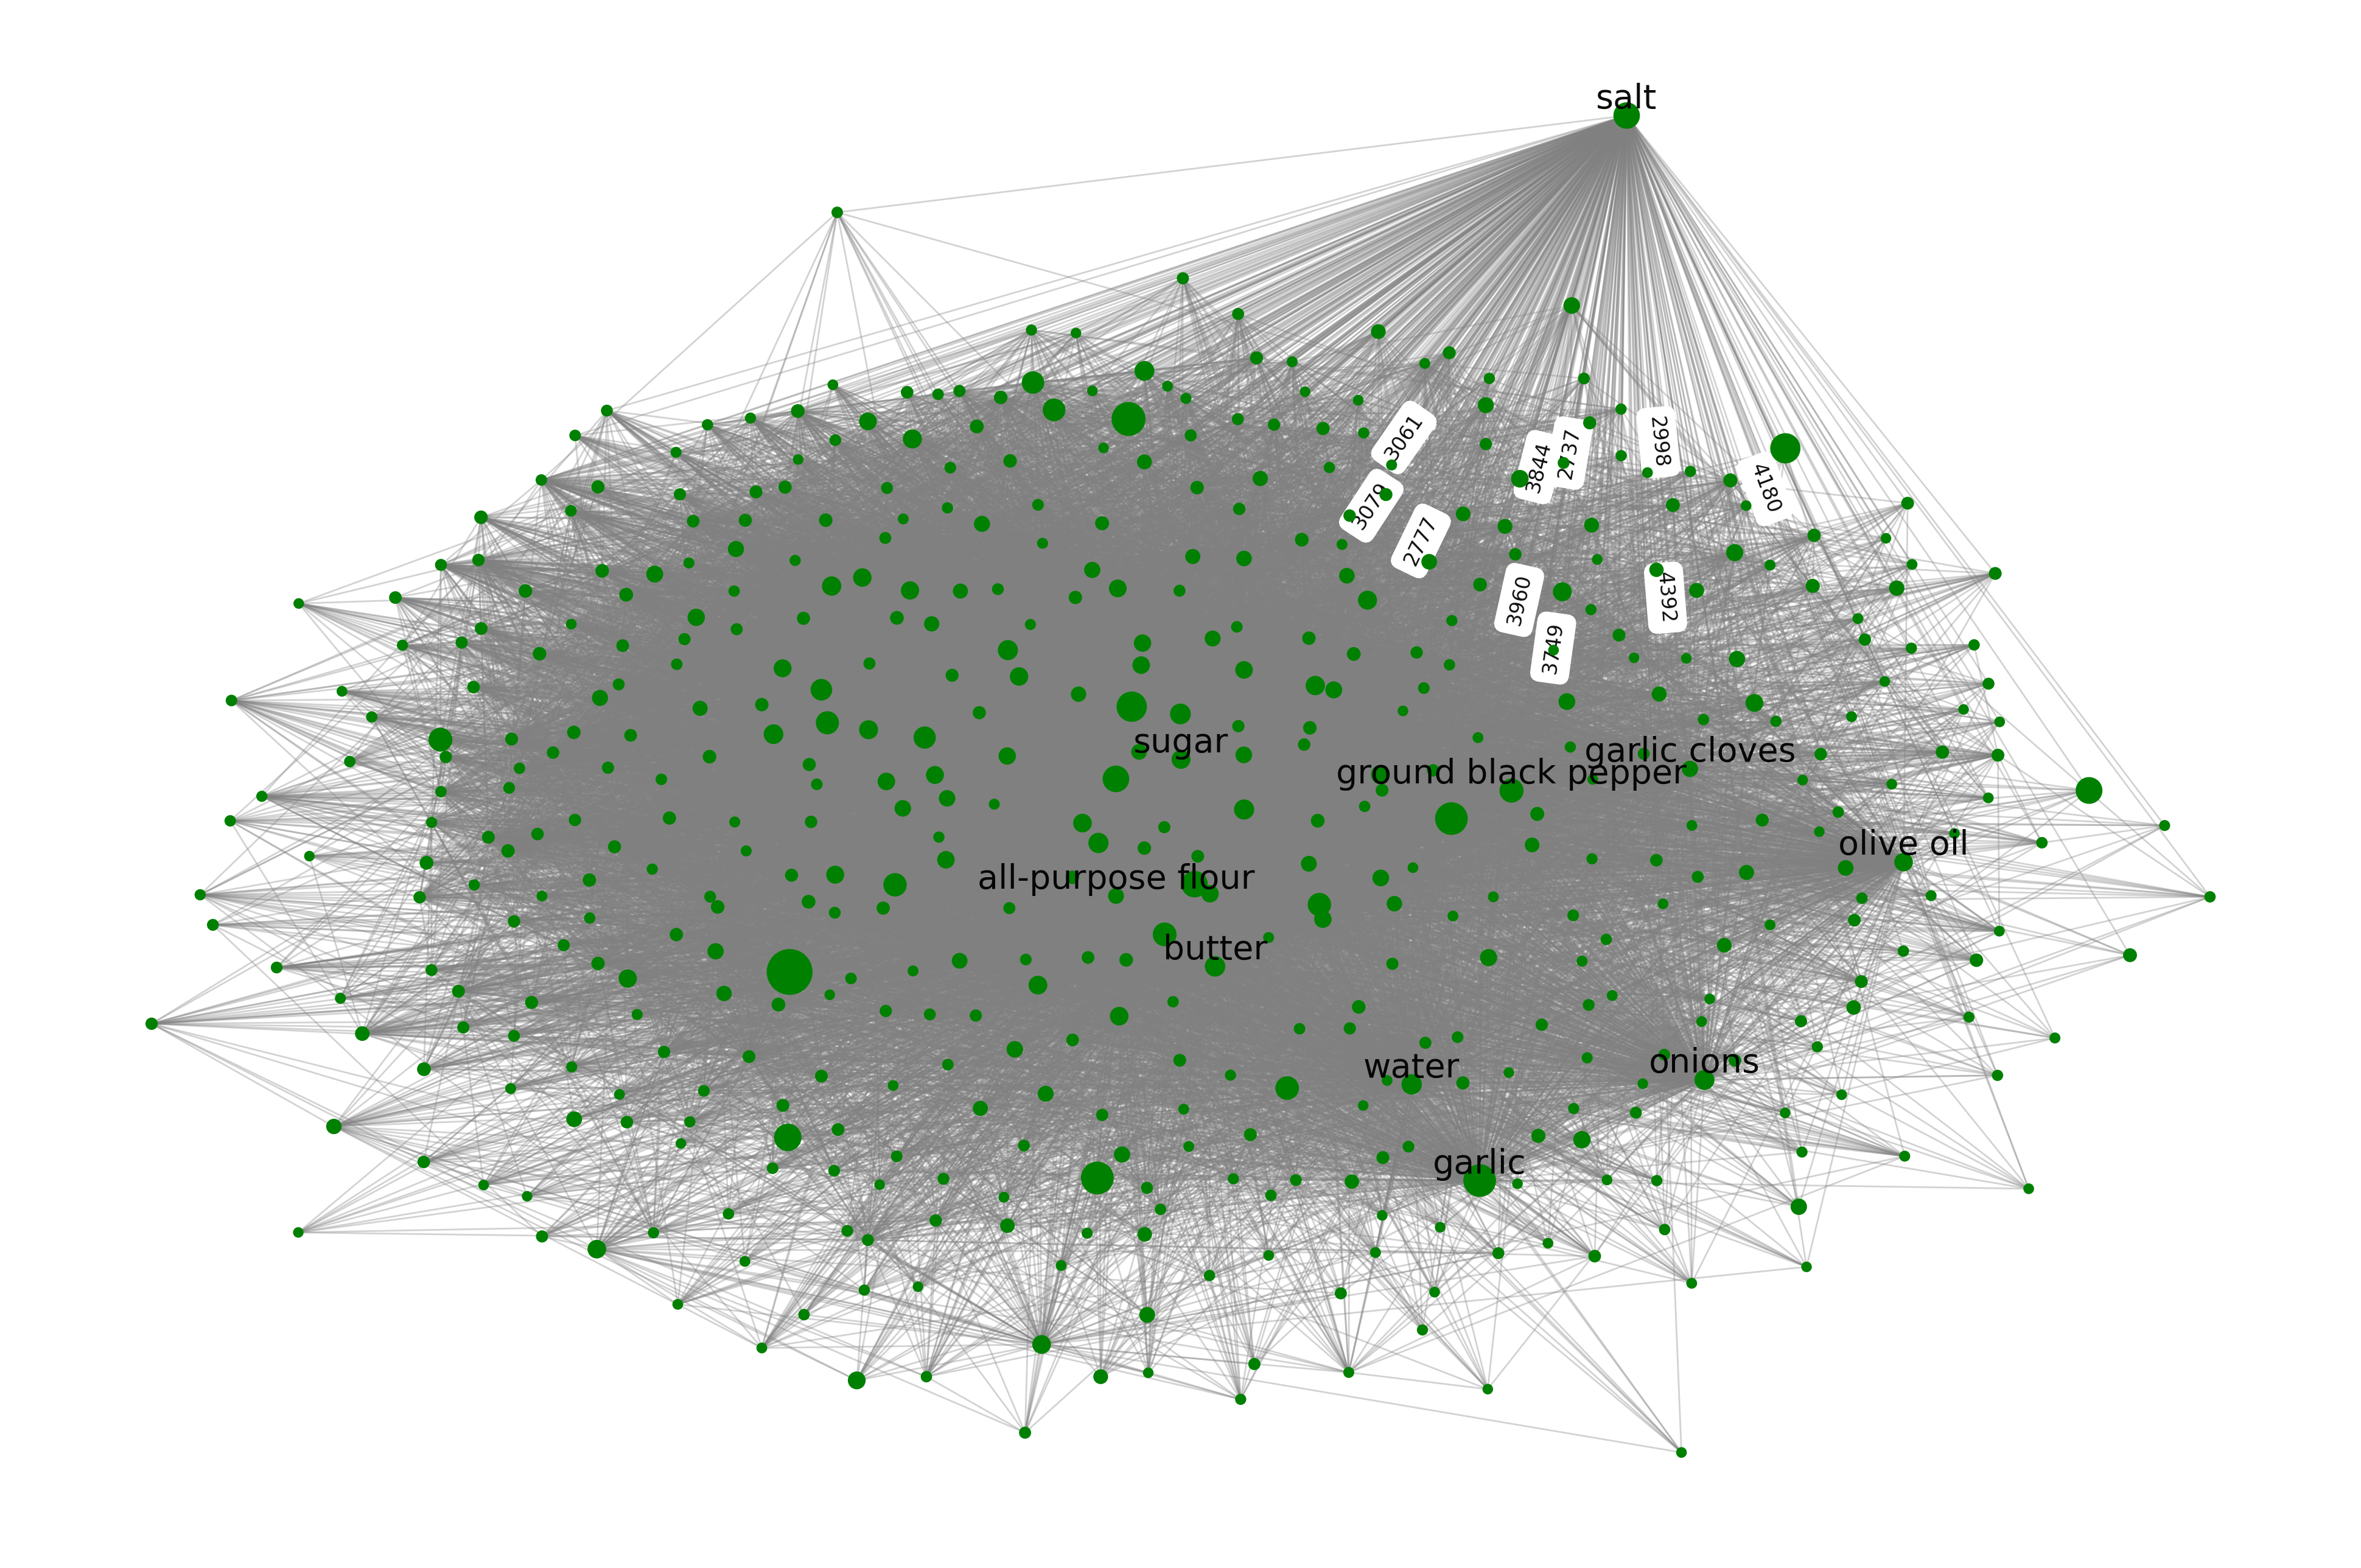

In [14]:
plot_graph(G, pagerank_G, 1000)

A continuación, se muestra una tabla con los 10 ingredientes (nodos) con mayor grado de centralidad.

In [15]:
sorted_nodes = {key: value for key, value in sorted(pagerank_G.items(), key = lambda item: item[1], reverse = True)[:10]}
sorted_nodes_df = pd.DataFrame.from_dict(sorted_nodes, orient = 'index', columns = ['Centralidad'])
sorted_nodes_df

Centralidad
salt                    0.033347
onions                  0.016112
garlic                  0.014836
olive oil               0.014705
water                   0.014646
garlic cloves           0.012146
sugar                   0.012020
ground black pepper     0.009357
butter                  0.008750
all-purpose flour       0.008606

A continuación, se muestra una tabla con las 10 relaciones entre un par de ingredientes (aristas) con mayor peso.

Se puede observar que en general las aristas con mayor peso son las que conectan un par de ingredientes con un alto grado de centralidad. De hecho tan solo un ingrediente ("pepper") de la siguiente tabla no está dentro del top 10 con mayor centralidad.

<span style="color:red"> 

- Me gusta esta observación!

</span>

In [16]:
sorted_edges = {(edge[0], edge[1]): edge[2]['weight'] for edge in sorted(G.edges(data = True), key = lambda item: item[2].get('weight', 1), reverse = True)[:10]}
sorted_edges_df = pd.DataFrame.from_dict(sorted_edges, orient = 'index', columns = ['Peso'])
sorted_edges_df

Peso
(salt, onions)               4392
(salt, olive oil)            4180
(salt, water)                3960
(pepper, salt)               3844
(garlic, salt)               3749
(salt, all-purpose flour)    3079
(salt, sugar)                3061
(salt, garlic cloves)        2998
(salt, butter)               2777
(salt, ground black pepper)  2737

## Parte 2: Representación en dos dimensiones del grafo de recetas

### 2.a Construyendo representaciones de baja dimensión para el grafo

Con el objetivo de ver clusters de ingredientes se realiza una representación de baja dimensión (100 especificamente) de los nodos del grafo de recetas, para esto se utiliza la librería node2vec. Posteriormente se hace una proyección en 2 dimensiones de los nodos utilizando el algoritmo TSNE implementado en la librería scikit-learn, con ello ya se puede graficar y, de ser posible, visualizar clusters de ingredientes.

<span style="color:red"> 

- Explica un poco más en detalle los objetivos de cada sección

</span>

In [ ]:
!pip3 install node2vec scikit-learn

In [17]:
import numpy as np
from node2vec import Node2Vec
from sklearn.manifold import TSNE

In [66]:
node2vec = Node2Vec(G, dimensions = 100, workers = 2)

Computing transition probabilities: 100%|████████████████████████████████████████████| 500/500 [00:31<00:00, 16.00it/s]


In [67]:
model = node2vec.fit(window = 10, min_count = 1)

In [68]:
model.wv.vocab

{'sweet potatoes': <gensim.models.keyedvectors.Vocab at 0x1fd20b85b80>,
 'cilantro': <gensim.models.keyedvectors.Vocab at 0x1fd20b85580>,
 'salt': <gensim.models.keyedvectors.Vocab at 0x1fd20b85280>,
 'brown sugar': <gensim.models.keyedvectors.Vocab at 0x1fd20b852e0>,
 'scallions': <gensim.models.keyedvectors.Vocab at 0x1fd1d62a670>,
 'sesame oil': <gensim.models.keyedvectors.Vocab at 0x1fd1d62a700>,
 'cayenne pepper': <gensim.models.keyedvectors.Vocab at 0x1fd1d62a760>,
 'sugar': <gensim.models.keyedvectors.Vocab at 0x1fd1d62a7c0>,
 'ground cumin': <gensim.models.keyedvectors.Vocab at 0x1fd1d62a970>,
 'purple onion': <gensim.models.keyedvectors.Vocab at 0x1fd1d62aac0>,
 'red bell pepper': <gensim.models.keyedvectors.Vocab at 0x1fd1d62ab20>,
 'part-skim mozzarella cheese': <gensim.models.keyedvectors.Vocab at 0x1fd1d62aca0>,
 'grated parmesan cheese': <gensim.models.keyedvectors.Vocab at 0x1fd1d62aeb0>,
 'spaghetti': <gensim.models.keyedvectors.Vocab at 0x1fd1d62af40>,
 'bay leaf': <ge

In [69]:
nodes = [x for x in model.wv.vocab]
embeddings = np.array([model.wv[x] for x in nodes])
embeddings

array([[-8.29585344e-02, -1.61380437e-03,  9.20928791e-02, ...,
         2.17372090e-01, -1.10032156e-01,  9.65675637e-02],
       [-5.04812717e-01, -7.88666308e-02, -3.03255767e-01, ...,
         1.28877193e-01,  6.56035900e-01, -1.70718893e-01],
       [-6.31609885e-03, -4.62425277e-02, -4.78842435e-03, ...,
         3.33352163e-02, -1.11956663e-01,  9.77415293e-02],
       ...,
       [ 2.32935935e-01, -1.54425707e-02,  2.56734133e-01, ...,
         1.52030855e-01, -6.15644574e-01,  1.84470639e-01],
       [-5.14536425e-02, -1.41617253e-01, -1.90466270e-01, ...,
        -1.32141663e-02,  9.04330537e-02,  1.98483810e-01],
       [ 3.10728084e-02, -2.32936189e-01, -6.76182136e-02, ...,
         1.29175154e-04, -1.21972062e-01,  1.33044779e-01]], dtype=float32)

In [70]:
X_embedded = TSNE(n_components = 2, perplexity = 20, random_state = 7)
X_embedded = X_embedded.fit_transform(embeddings)
X_embedded.shape

(500, 2)

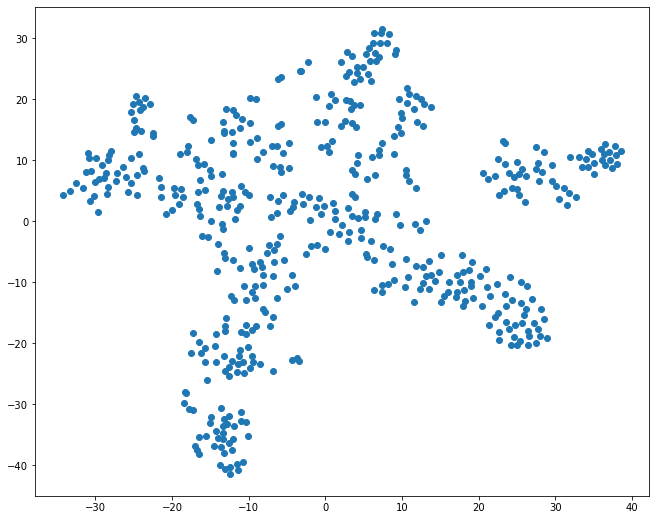

In [71]:
figure = plt.figure(figsize = (11, 9))
ax = figure.add_subplot(111)
ax.scatter(X_embedded[:, 0], X_embedded[:, 1])

<span style="color:red"> 

- Esta figura podría llevar una mini explicación

</span>

### 2.b Aplicando el algoritmo de clustering K-Means

A continuación, se aplica el algoritmo de clustering K-Means el cual también está implementado en la librería scikit-learn. Sin embargo, primero es necesario evaluar cuál es el número de clusters más adecuado para indicarle al algoritmo. Para esto se han propuesto dos formas, la [primera](https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/) es generar una curva en la cual se busca el "punto de codo", la otra forma es usando la función "silhouette_score" y revisar el puntaje obtenido para cada X número de clusters probado.

Con la primera forma se puede observar que 4 y 6 clusters parecen ser los más adecuados, ya que son los puntos donde se ve un menor ángulo en la curva.

In [72]:
from sklearn.cluster import KMeans

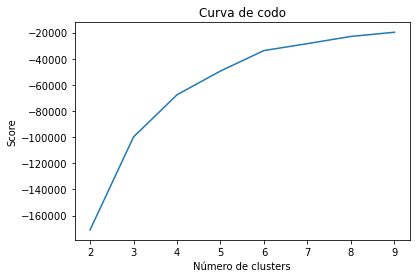

In [73]:
Nc = range(2, 10)
kmeans = [KMeans(n_clusters = i) for i in Nc]
score = [kmeans[i].fit(X_embedded).score(X_embedded) for i in range(len(kmeans))]

plt.plot(Nc, score)
plt.xlabel('Número de clusters')
plt.ylabel('Score')
plt.title('Curva de codo')
plt.show()

En el caso del silhouette score, el número de clusters 6 es donde se aprecia un punto de "corte" o cambio.

In [74]:
from sklearn.metrics import silhouette_score

In [75]:
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters = n_clusters)
    preds = clusterer.fit_predict(X_embedded)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X_embedded, preds)
    print('Para {} clusters, el silhouette score es {}'.format(n_clusters, score))

Para 2 clusters, el silhouette score es 0.38408055901527405
Para 3 clusters, el silhouette score es 0.45216822624206543
Para 4 clusters, el silhouette score es 0.44836291670799255
Para 5 clusters, el silhouette score es 0.4911371171474457
Para 6 clusters, el silhouette score es 0.5076324343681335
Para 7 clusters, el silhouette score es 0.5020943880081177
Para 8 clusters, el silhouette score es 0.4925139844417572
Para 9 clusters, el silhouette score es 0.48344317078590393


Con la función "silhouette_score" se observa que con 6 clusters existe una diferencia significativa con respecto a las cantidades de cluster vecinas (5 y 7). Por lo que finalmente se ha decidido optar por 6 como el número de clusters a usar en el algoritmo K-Means para graficar posteriormente.

<span style="color:red"> 

- Está ok que mezcles dos formas de hacer esto
</span>

In [76]:
def plot_chart():
    kmeans = KMeans(n_clusters = 6).fit(X_embedded)
    labels = kmeans.predict(X_embedded)
    centroids = kmeans.cluster_centers_

    top_centrality_idxs = list()
    for key, value in sorted_nodes.items():
        top_centrality_idxs.append(nodes.index(key))

    figure = plt.figure(figsize = (11, 9))
    ax = figure.add_subplot(111)

    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c = labels.astype(float), s = 60)
    ax.scatter(centroids[:, 0], centroids[:, 1], c = 'red', marker = '*', s = 1000)
    ax.scatter(
        X_embedded.take(top_centrality_idxs, 0)[:, 0],
        X_embedded.take(top_centrality_idxs, 0)[:, 1],
        c = 'orange',
        marker = '*',
        s = 350
    )
    return ax

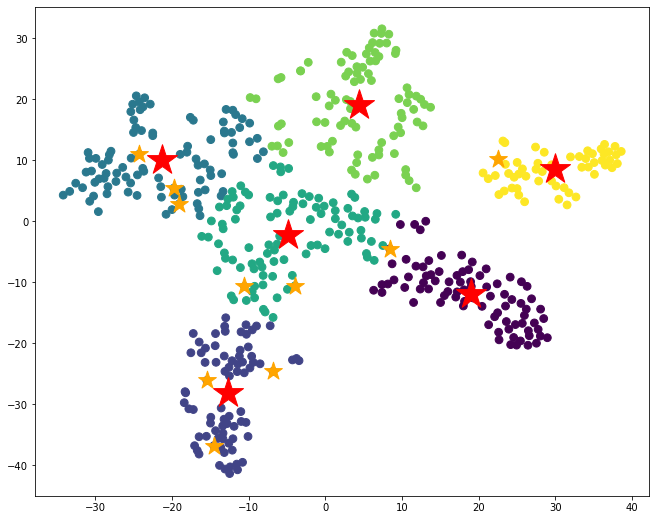

In [77]:
plot_chart()

*Notar que los centroides de cada cluster están representados por estrellas rojas, mientras que aquellos nodos que entran en el top 10 de mayor centralidad están representados por estrellas naranjas.*

Como se logra visualizar, el gráfico muestra que los ingredientes se agrupan en 6 clusters, los que están diferenciados en el gráfico por su color. Si bien no se logra observar una separación significativa entre clusters, de hecho están relativamente cerca uno del otro, si se marcan esquinas o vértices de ingredientes alrededor del cluster central, con lo que se puede diferenciar un cluster de otro fácilmente.

Además no se puede concluir que haya una relación de cercanía entre los centroides y los nodos con mayor centralidad, ya que estos últimos se encuentran dispersos de manera no uniforme a lo largo y ancho del gráfico.

<span style="color:red"> 

- Esto último es interesante
    
</span>

### 2.c Análisis extra

A continuación, se procesan los datos de recetas con el objetivo de generar rankings de frecuencia de ingredientes para cada tipo de cocina. Adicionalmente las cocinas se agrupan por la zona o región geográfica a la que pertenecen, esto permite visualizar si existen ingredientes comúnes entre cocinas de una misma región, ya que se puede entender que, por ejemplo, las cocinas de China, Corea y Japón tienen grandes similitudes, pero se diferencian en gran medida de las cocinas de occidente.

Se han establecido 6 regiones distintas, haciendo un símil con el número de clusters usados. Estas regiones son las siguientes:
* África (**AF**): solo agrupa a la cocina marroquí, ya que es la única presente en los datos que pertenece a África.
* América (**AM**): agrupa a las cocinas de brasileña, criolla de Luisiana, jamaicana, mexicana y del sur de EEUU.
* Asia (**AS**): solo agrupa a la cocina indú, ya que según sus ingredientes, se diferencia de las cocinas de regiones cercanas como Asia Oriental y Sudeste Asiático.
* Asia Oriental (**AO**): agrupa a las cocinas china, japonesa y coreana.
* Sudeste Asiático (**SA**): agrupa a las cocinas filipina, tailandesa y vietnamita.
* Europa (**EU**): agrupa a las cocinas británica, francesa, greca, italiana, española y rusa, esta última debido a que se asemeja más a las cocinas de Europa que a las de Asia.

*Notar que aquellos ingredientes que están dentro de los 10 de mayor centralidad están marcados con el símbolo * (asterísco) como sufijo.*

<span style="color:red"> 

- Me gusta esta parte, creo que solo falta explicar con un poco más de detalle, y con cierto cuidado por la redacción
</span>

In [78]:
cuisines_ingredients = dict()
for recipe in data:
    cuisine = recipe['cuisine']
    if(cuisine not in cuisines_ingredients):
        cuisines_ingredients[cuisine] = dict()

    for ingredient in recipe['ingredients']:
        if(ingredient in cuisines_ingredients[cuisine]):
            cuisines_ingredients[cuisine][ingredient] += 1
        else:
            cuisines_ingredients[cuisine][ingredient] = 1

for cuisineKey, cuisineValue in cuisines_ingredients.items():
    for ingredient, value in sorted_nodes.items():
        if(ingredient in cuisineValue):
            cuisineValue[ingredient + ' *'] = cuisineValue.pop(ingredient)

In [79]:
from IPython.display import display

def top_region_cuisines(region, order_by = None):
    def order_ingredients(cuisine):
        top = [key for key, value in sorted(cuisines_ingredients[cuisine].items(), key = lambda item: item[1], reverse = True)[:10]]
        top = [ingredient for ingredient in sorted(top)]
        return top
    
    region_cuisines = {
        'África': ['moroccan'],
        'América': ['brazilian', 'cajun_creole', 'jamaican', 'mexican', 'southern_us'],
        'Asia': ['indian'],
        'Asia Oriental': ['chinese', 'japanese', 'korean'],
        'Sudeste Asiático': ['filipino', 'thai', 'vietnamese'],
        'Europa': ['british', 'french', 'greek', 'italian', 'spanish', 'russian']
    }

    if order_by == None:
        order_by = region_cuisines[region][0]
    
    df = pd.DataFrame.from_dict(
        {key: order_ingredients(key) for key in region_cuisines[region]},
        orient = 'columns'
    ).head(10)

    display(df)

El origen de las cocinas de América presentes en los datos es bastante heterogéneo, por lo que, excluyendo aquellos que tienen mayor centralidad, es difícil encontrar ingredientes compartidos entre ellas.

De todas formas, se puede destacar que el ingrediente 'all-purpose flour' está presente en la cocina criolla de Luisiana y del sur de EEUU, esto tiene sentido considerando que son cocinas pertenecientes a zonas geográficas que están muy cerca una de la otra.

In [80]:
top_region_cuisines('América')

brazilian         cajun_creole         jamaican           mexican  \
0          cachaca  all-purpose flour *     black pepper           avocado   
1         garlic *             butter *      dried thyme      chili powder   
2  garlic cloves *      cajun seasoning         garlic *    corn tortillas   
3             lime       cayenne pepper  garlic cloves *          garlic *   
4      olive oil *             garlic *  ground allspice      ground cumin   
5         onions *    green bell pepper         onions *  jalapeno chilies   
6           salt *          olive oil *           pepper       olive oil *   
7          sugar *             onions *           salt *          onions *   
8         tomatoes               salt *        scallions            salt *   
9          water *              water *          water *        sour cream   

           southern_us  
0  all-purpose flour *  
1        baking powder  
2             butter *  
3           buttermilk  
4           large eggs  
5                 milk  
6               salt *  
7              sugar *  
8      unsalted butter  
9              water *

La cocina indú contempla ingredientes que no suelen estar tan presentes en el resto de las cocinas, algunos de estos son 'cumin seed', 'garam masala' y 'ground turmeric', los cuales solo aparecerán en esta tabla.

In [81]:
top_region_cuisines('Asia')

indian
0       cumin seed
1     garam masala
2         garlic *
3     ground cumin
4  ground turmeric
5              oil
6         onions *
7           salt *
8    vegetable oil
9          water *

Las cocinas de Asia Oriental son de las que tienen mayor similitud al menos dentro del límite de los datos procesados. Aquí se pueden destacar ingredientes como 'green onions', 'scallions', 'sesame oil', 'soy sauce' y 'vegetable oil' los que están presentes en más de una cocina.

In [82]:
top_region_cuisines('Asia Oriental')

chinese       japanese        korean
0    corn starch         ginger      garlic *
1       garlic *          mirin  green onions
2   green onions   rice vinegar      onions *
3         salt *           sake        salt *
4      scallions         salt *     scallions
5     sesame oil      scallions    sesame oil
6      soy sauce      soy sauce  sesame seeds
7        sugar *        sugar *     soy sauce
8  vegetable oil  vegetable oil       sugar *
9        water *        water *       water *

Al igual que las cocinas de Asia Oriental, las del Sudeste Asiático comparten varios ingredientes entre sí, tales como: 'carrots', 'fish sauce', 'soy sauce' y 'vegetable oil'.

In [83]:
top_region_cuisines('Sudeste Asiático')

filipino              thai       vietnamese
0                carrots      coconut milk          carrots
1               garlic *        fish sauce       fish sauce
2  ground black pepper *  fresh lime juice         garlic *
3                    oil          garlic *  garlic cloves *
4               onions *   garlic cloves *           salt *
5                 pepper            salt *         shallots
6                 salt *         soy sauce        soy sauce
7              soy sauce           sugar *          sugar *
8                sugar *     vegetable oil    vegetable oil
9                water *           water *          water *

Las cocinas de Europa también mantienen un cierto grado de similitud, ya que salvo por la greca, estas cocinas comparten una gran cantidad de ingredientes comunes, algunos de los cuales son: 'all-purpose flour', 'butter', 'extra-virgin olive oil', 'ground black pepper', 'eggs', 'large eggs' y 'unsalted butter'.

In [84]:
top_region_cuisines('Europa')

british                 french                   greek  \
0  all-purpose flour *    all-purpose flour *           dried oregano   
1        baking powder               butter *  extra-virgin olive oil   
2             butter *        garlic cloves *    feta cheese crumbles   
3                 eggs  ground black pepper *       fresh lemon juice   
4           large eggs             large eggs                garlic *   
5                 milk            olive oil *         garlic cloves *   
6             onions *                 salt *   ground black pepper *   
7               salt *                sugar *             olive oil *   
8              sugar *        unsalted butter                  pepper   
9      unsalted butter                water *                  salt *   

                  italian                 spanish              russian  
0                butter *  extra-virgin olive oil  all-purpose flour *  
1  extra-virgin olive oil         garlic cloves *             butter *  
2                garlic *   ground black pepper *                 eggs  
3         garlic cloves *             olive oil *           large eggs  
4  grated parmesan cheese                onions *             onions *  
5   ground black pepper *                  pepper               salt *  
6             olive oil *         red bell pepper           sour cream  
7                onions *                  salt *              sugar *  
8                  salt *                tomatoes      unsalted butter  
9                 water *                 water *              water *

Similar a lo que ocurre con la cocina indú, la cocina marroquí se diferencia del resto por varios de sus ingredientes, tales como: 'ground cinnamon', 'ground cumin', 'ground ginge' y 'paprika'.

In [85]:
top_region_cuisines('África')

moroccan
0          carrots
1  garlic cloves *
2  ground cinnamon
3     ground cumin
4    ground ginger
5      olive oil *
6         onions *
7          paprika
8           salt *
9          water *

Finalmente se grafican nuevamente los clusters de nodos. Esta vez se agregan etiquetas (con la abreviación de la región) a aquellos ingredientes que son más relevantes para cada agrupación de cocinas. Que un ingrediente sea relevante para un conjunto de cocinas de una misma región, quiere decir que dicho ingrediente se repite en más de una cocina de esta agrupación y/o es un ingrediente que hace que el conjunto de cocinas sea distinto al resto de conjuntos, ya que no suele estar tan presente en las cocinas de otras regiones.

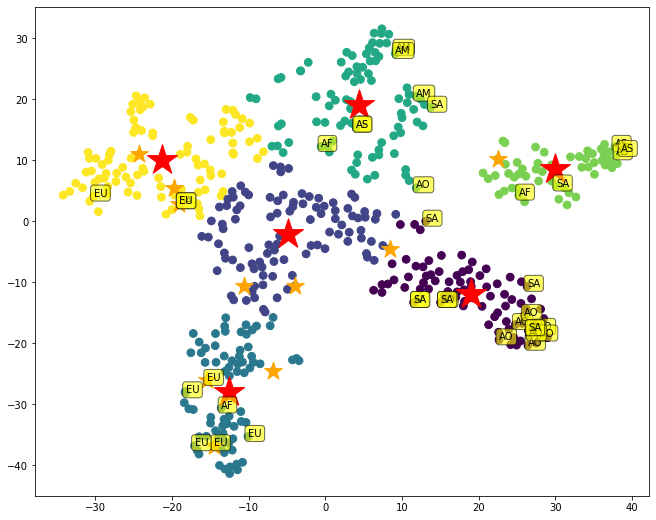

In [86]:
# AF: África; AM: América; AS: Asia; AO: Asia Oriental; SA: Sudeste Asiático; EU: Europa
featured_ingredients = {
    'AF': ['carrots', 'ground cinnamon', 'ground cumin', 'ground ginger', 'paprika'],
    'AM': ['avocado', 'corn tortillas', 'lime'],
    'AS': ['cumin seed', 'garam masala', 'ground cumin', 'ground turmeric'],
    'AO': [
        'corn starch', 'mirin', 'green onions', 'rice vinegar', 'sake', 'scallions', 'sesame oil', 'soy sauce',
        'sesame seeds', 'vegetable oil'
    ],
    'SA': [
        'carrots', 'coconut milk', 'fish sauce', 'ground black pepper', 'fresh lime juice', 'shallots',
        'soy sauce', 'vegetable oil'
    ],
    'EU': [
        'all-purpose flour', 'butter', 'extra-virgin olive oil', 'ground black pepper', 'eggs', 'large eggs',
        'unsalted butter'
    ]
}

label_idxs_region = list()
for region, ingredients in featured_ingredients.items():
    for ingredient in ingredients:
        label_idxs_region.append((region, nodes.index(ingredient)))

ax = plot_chart()
for region, idx in label_idxs_region:
    ax.annotate(
        region,
        (X_embedded[idx, 0], X_embedded[idx, 1]),
        bbox = dict(boxstyle = 'round', fc = 'yellow', alpha = 0.6)
    )

Se logra observar que los ingredientes de una misma región suelen estar más cerca uno del otro que con los ingredientes de las cocinas de otras regiones. Esto se puede ver mayormente en aquellos de las cocinas de Europa (EU), Asia (AS) y Asia Oriental (AO) junto a sus pares del Sudeste Asiático (SA). Y en menor medida se pueden ver aquellos de las cocinas de América (AM).